# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 316496025, 307851311 ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

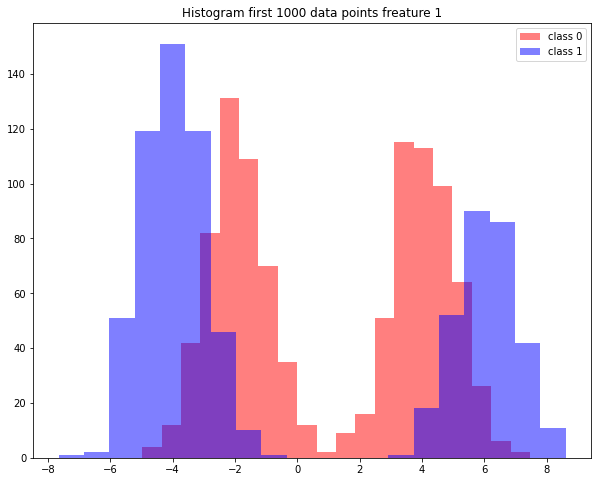

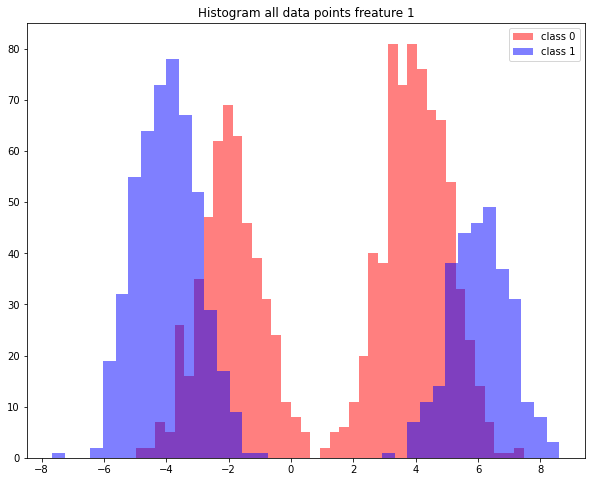

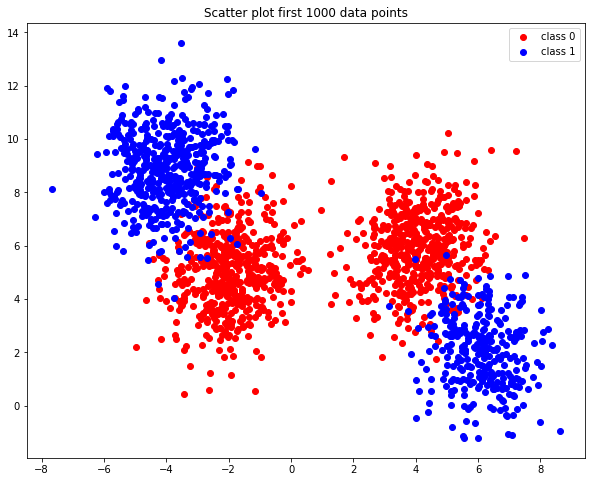

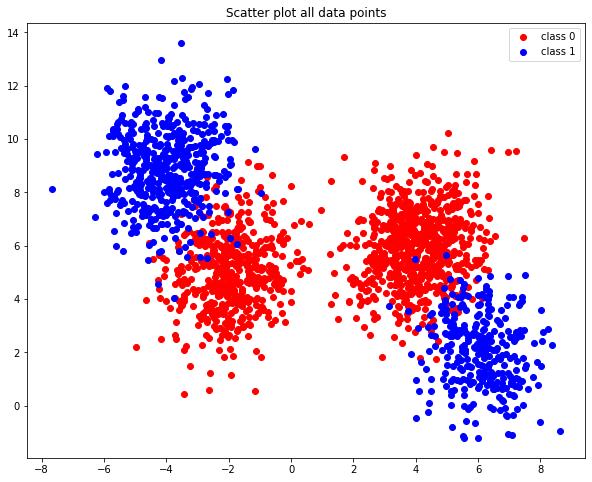

In [4]:
#### Your code here ####
relTrain_set = training_set.values
cls0 = relTrain_set[relTrain_set[:,-1] == 0]
cls1 = relTrain_set[relTrain_set[:,-1] == 1] 
plt.title("Histogram first 1000 data points freature 1")
plt.hist(cls0[:1000,0],bins = 20,alpha=0.5,color = 'red')
plt.hist(cls1[:1000,0],bins = 20,alpha=0.5, color = 'blue')
plt.legend(["class 0", "class 1"])
plt.show()
plt.title("Histogram all data points freature 1")
plt.hist(cls0[:,0],bins = 40,alpha=0.5, color = 'red')
plt.hist(cls1[:,0],bins = 40,alpha=0.5, color = 'blue')
plt.legend(["class 0", "class 1"])
plt.show()
plt.title("Scatter plot first 1000 data points")
plt.scatter(cls0[:1000,0],cls0[:1000,1],color = 'red')
plt.scatter(cls1[:1000,0],cls1[:1000,1],color = 'blue')
plt.legend(["class 0", "class 1"])
plt.show()
plt.title("Scatter plot all data points")
plt.scatter(cls0[:,0],cls0[:,1],color = 'red')
plt.scatter(cls1[:,0],cls1[:,1],color = 'blue')
plt.legend(["class 0", "class 1"])
plt.show()




## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = np.array([0,0])
        
    def sig(self,x):
        
        """
    Parameters
    ------------
    x: instance
        """
        res = 1/(1+np.exp(-1*np.dot(x,self.theta)))
        return res
    
    def cost(self,X,y):
        res = (-1/X.shape[0]) * np.sum(y*np.log(self.sig(X)) + (1-y)*np.log(1-(self.sig(X))))
        return res
            
    
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        try:
            X = np.column_stack((np.ones(X.shape[0]),X))
        except:
            print(X.shape)
            print(np.ones(X.shape[0]).shape)
            return
        np.random.seed(self.random_state)
        self.theta = np.random.rand(X.shape[1])
        costHistory=[]
        for i in range(self.n_iter):
            curCost = self.cost(X,y)
            costHistory.append(curCost)
            temp = (self.sig(X)-y)*X.T
            self.theta -= self.eta*np.sum(temp,axis = 1)
            if len(costHistory)>1:
                if np.absolute(costHistory[-2]-curCost) <=self.eps:
                    return costHistory;
        return costHistory
    
    def predict(self, X):        
        return (np.around(self.sig(np.column_stack((np.ones(X.shape[0]),X)))))
            

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [6]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
res = {}

for eta in etas:
    for eps in epss:
        sheffled_df = training_set.sample(frac=1)
        X_data,y_data = sheffled_df[['x1', 'x2']].values, sheffled_df['y'].values

        splitted_X = np.array_split(X_data,5)
        splitted_y = np.array_split(y_data,5)
        model =  LogisticRegressionGD(eta=eta, eps=eps)         
        accuracy=0
        for i in range(5):
            X = np.concatenate(splitted_X[:i]+splitted_X[i+1:])
            X_val = splitted_X[i]
            y= np.concatenate(splitted_y[:i]+splitted_y[i+1:])
            y_val = splitted_y[i]
            model.fit(X,y)
            accuracy +=np.sum(1-np.abs(model.predict(X_val) - y_val))/X_val.shape[0]
        accuracy/=5
        res[accuracy]=(eta,eps)
eta, eps = res[max(res.keys())]
print(f"best eta is {eta} and best eps is {eps}")

        
        
            
            
            
        
        
        
        

best eta is 5e-05 and best eps is 1e-06


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [7]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return np.exp(-0.5*((data-mu)/sigma)**2)/(sigma*(2*np.pi)**0.5)
   


## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [8]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.means = np.empty(self.k)
        self.stds = np.empty(self.k)

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        x = np.sort(data)
        split = np.array_split(x,self.k)
        for i in range(len(split)):
            self.means[i] = np.mean(split[i])
            self.stds[i] = np.std(split[i])
        
        self.weights = np.ones(self.k)/self.k
        
                
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        resMatrix = np.empty([self.k,data.shape[0]])
        for i in range(self.k):
            resMatrix[i] = norm_pdf(data,self.means[i],self.stds[i])*self.weights[i]
        sumVec = np.sum(resMatrix,axis = 0)
        resMatrix = resMatrix / sumVec
        self.resMatrix = resMatrix
        
        
            
        
        

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        self.weights = np.sum(self.resMatrix,axis = 1)/data.shape[0]
        self.means = np.sum(self.resMatrix * data,axis=1)/(self.weights * data.shape[0])
        stdMatrix = np.ones_like(self.resMatrix) * data
        stdMatrix = (stdMatrix.T- self.means).T**2*self.resMatrix # vectorized calculation of new stds
        self.stds = (np.sum(stdMatrix,axis =1) / (self.weights * data.shape[0]))**0.5
        
    def calcCost(self,data):
        
        return np.sum(-1*np.log(self.calcMixturePdf(data)))
    
    def calcMixturePdf(self,data):
        agg = np.zeros_like(data)
        for i in range(self.k):
            agg += self.weights[i]*norm_pdf(data,self.means[i],self.stds[i])
        return agg
        
        
        

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        prevCost = 0
        for i in range(self.n_iter):
            self.expectation(data)
            self.maximization(data)
            cost = self.calcCost(data)
            if abs(cost - prevCost)<= self.eps:
                break
            else:
                prevCost = cost

    def get_dist_params(self):
        return self.means,self.stds,self.weights
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [9]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1,random_state=1):
        self.k = k
        self.random_state=random_state

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        clss,counts = np.unique(y,return_counts=True)
        self.prior = dict(zip(clss,counts/y.shape[0]))
        self.likelihood={}
        for cls in clss:
            self.likelihood[cls] = {}
            for i in range(X.shape[1]):
                model = EM(k=self.k)
                model.fit(X[y==cls,i])
                self.likelihood[cls][i] = model
        
            
            
        
        
    
    def predict(self, X):
        """Return the predicted class label"""
        
        predictionMat = np.empty_like(X)
        for cls in self.likelihood:
            prod = np.ones(X.shape[0])
            for feature in range(X.shape[1]):
                prod *= self.likelihood[cls][feature].calcMixturePdf(X[:,feature])
            predictionMat[:,cls] = prod * self.prior[cls]
        
        return np.argmax(predictionMat,axis=1)
            
            


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [10]:
def calcAccuracy(X,y,model):
    return np.sum(1-np.abs(y-model.predict(X)))/X.shape[0]
def evaluateModel(X_train,y_train,X_test,y_test,title1,title2):
    logist = LogisticRegressionGD(eta = 5e-05,eps = 1e-06)
    gaussian = NaiveBayesGaussian(k=4)
    costHistory = logist.fit(X_train,y_train)
    gaussian.fit(X_train,y_train)
    print(f"Accurecy rate of the Logistic Regression model on {title1} of train set is {calcAccuracy(X_train,y_train,logist)}")
    print(f"Accurecy rate of the Logistic Regression model on {title2} of test set is {calcAccuracy(X_test,y_test,logist)}")
    print(f"Accurecy rate of the Naive Bayes model on {title1} of train set is {calcAccuracy(X_train,y_train,gaussian)}")
    print(f"Accurecy rate of the Naive Bayes model on {title2} of test set is {calcAccuracy(X_test,y_test,gaussian)}")
    plot_decision_regions(X_train,y_train,logist)
    plt.title(f"Logistic Regression -  {title1}")
    plt.show()
    plt.title(f"Naive Bayes -  {title1}")
    plot_decision_regions(X_train,y_train,gaussian)
    plt.show()
    plt.title(f"cost Vs the iteration number for the Logistic Regression model - {title1}")
    plt.plot(np.arange(len(costHistory)),costHistory)
    plt.xlabel("Iteration"), plt.ylabel("Cost")
    plt.show()

Accurecy rate of the Logistic Regression model on first 1000 instances of train set is 0.965
Accurecy rate of the Logistic Regression model on first 500 instances of test set is 0.938
Accurecy rate of the Naive Bayes model on first 1000 instances of train set is 0.966
Accurecy rate of the Naive Bayes model on first 500 instances of test set is 0.942


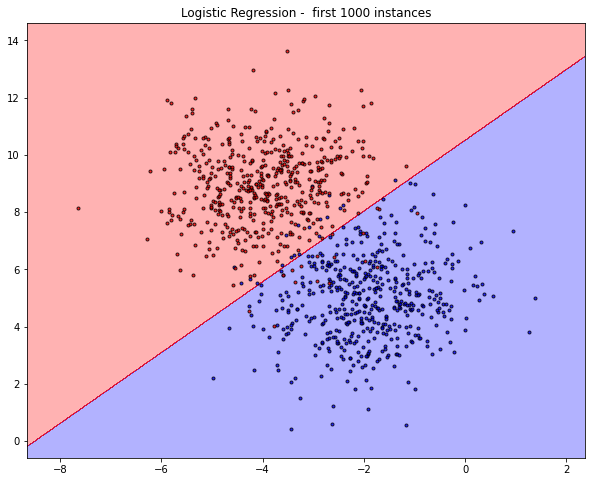

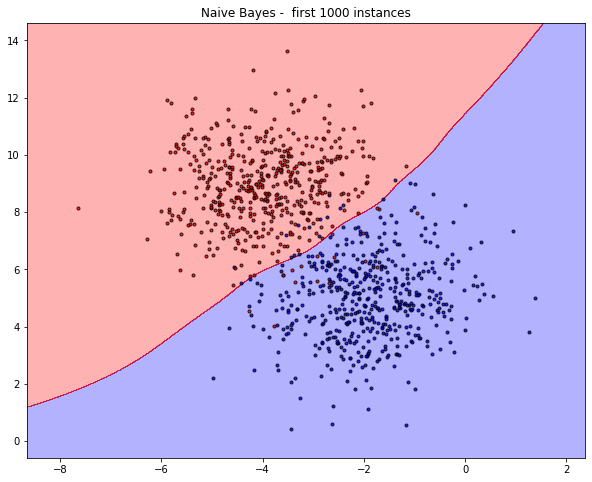

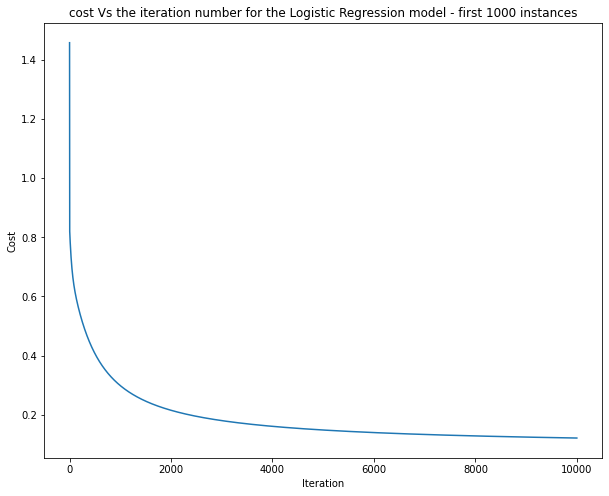

Accurecy rate of the Logistic Regression model on all instances of train set is 0.809
Accurecy rate of the Logistic Regression model on all instances of test set is 0.804
Accurecy rate of the Naive Bayes model on all instances of train set is 0.9195
Accurecy rate of the Naive Bayes model on all instances of test set is 0.904


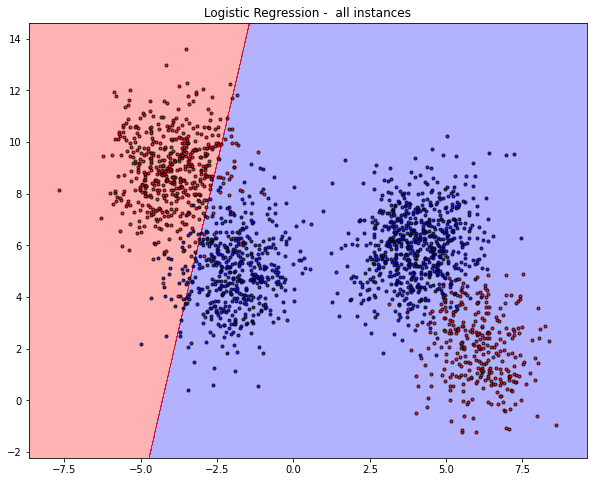

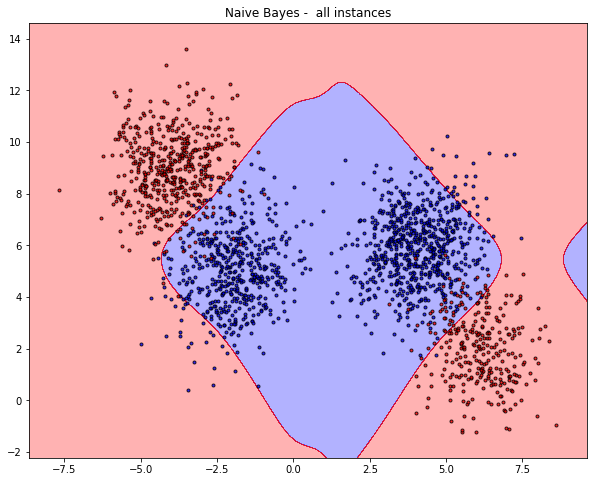

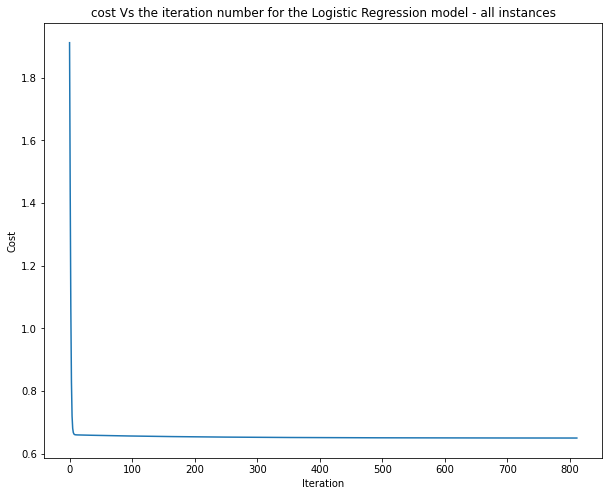

In [11]:
evaluateModel(X_training[:1000],y_training[:1000],X_test[:500],y_test[:500],"first 1000 instances","first 500 instances")
evaluateModel(X_training,y_training,X_test,y_test,"all instances","all instances")

## graph observations #

#### Logistic regression - 1000 Instances ####
in the first graph we can see that the 3 thethas that the model finds form a linear seperator on the data which
is relativly linearly seperable in two dimentions.

#### Gaussian Naive Bayes - 1000 Instances ####
now we can see that the model is not bound to seperate the data using linear seprator and is more closly to the distribution of the data

#### cost VS Iteration - 1000 Instances ####
we can see that the data is seperated quite nicely and we have a small cost in the end. furthermore we can see that the training fase of the model required all 10000 iteration and did not reached eps.

#### Logistic regression - All instances ####
here we can see that with all Instances the data is not linearly seperable in two dimention. thus the model seperates to the red class with respect to the largest cluster of the red class

#### Gaussian Naive Bayes - All Instances ####
we can see that this model can seperate better data which is not lineary seperable. giving the model 4 gausians for each feature gave it more freedom to fit the data better.

#### cost VS Iteration - All Instances ####
because the complexity of the data we can see that our cost in the end is still high maybe because the model finishes training (reaches eps in cost difference) quite quickly after 800 iteration or so.


## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


In [12]:
x1 = np.random.normal(0,1,1000)
x2 = np.random.normal(0,1,1000)
yd1 = ((x1**2+x2**2)<1).astype(int)
Xd1 = np.column_stack((x1,x2))

the first dataset we have created feature 1000 point with x and y independently normal destributed around 0. then we have created an inner circle at (0,0) with a radius of 1 and fixed all the instances inside the circle to be of class 1 and outside the circle to be class 0. this dataset is of cours not linearly seperable in 2d and thus logistic regresion will preform poorly on it. On the other hand because the features are disributed normaly independently naive bayes with EM will be able to seperate it quite easily.

In [13]:
x1c0 = np.random.normal(1,2,500)
x2c0 = x1c0*2 + np.random.normal(0,0.5,500)
x1c1 = np.random.normal(1,2,500)
x2c1 = x1c1*2 + np.random.normal(0,0.5,500)+5
mat1 = np.column_stack((x1c0,x2c0))
mat2 = np.column_stack((x1c1,x2c1))
Xd2 = np.vstack((mat1,mat2))
yd2= np.hstack((np.zeros(500).astype(int),np.ones(500).astype(int)))

the second dataset we have created have for x1 value normal distribution around 1 and for x2 value we have $2*x1$ plus some noise which is normaly distributed around 0. we have created seperation between the classes by adding 5 to x2 feature of class 1 forming a dataset which is linearly seperable. because the features x1 and x2 of each class are closely distributed naive bayes learns very little on the clasification of each instance when he looks at each feature seperetly. thus naive bayes performs quite poorly on this dataset while logistic regression performs nicely due to the fact that the data is linearly seperable.

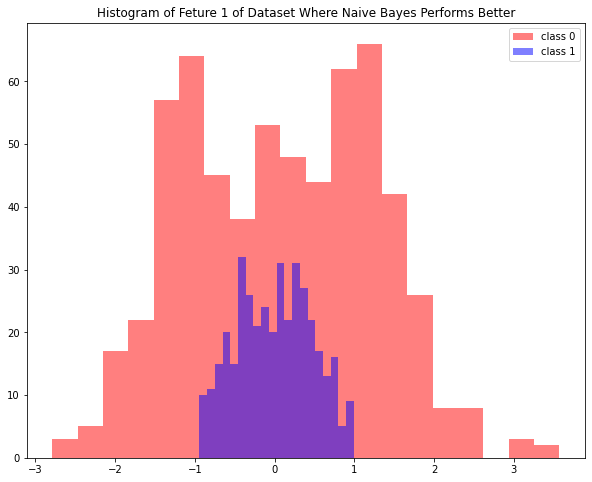

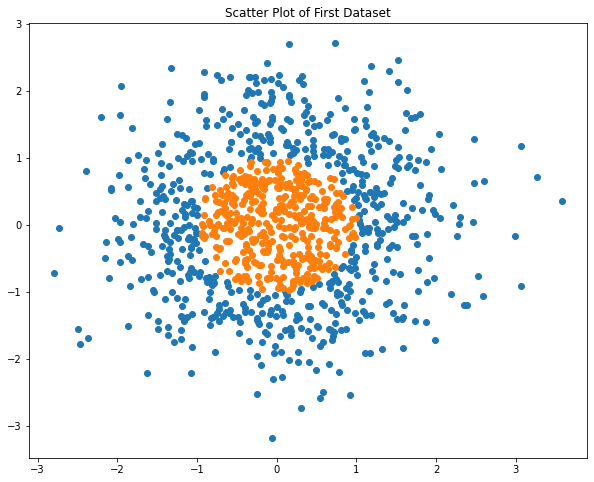

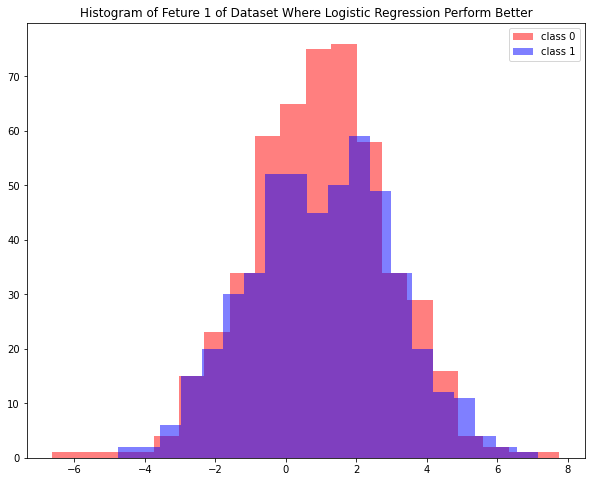

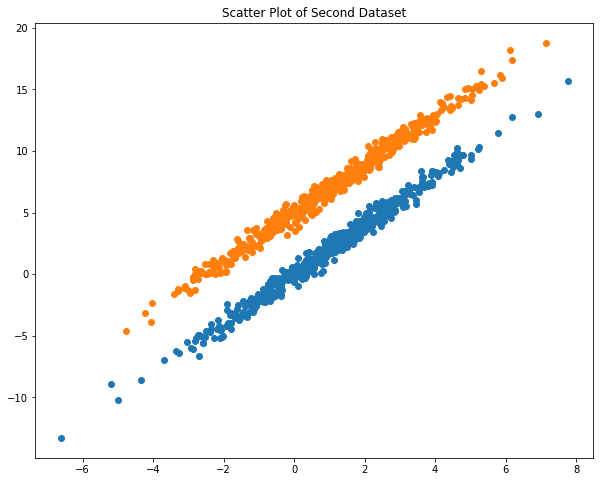

In [14]:
plt.title("Histogram of Feture 1 of Dataset Where Naive Bayes Performs Better")
plt.hist(x1[yd1==0],bins = 20,alpha=0.5,color = 'red')
plt.hist(x1[yd1==1],bins = 20,alpha=0.5, color = 'blue')
plt.legend(["class 0", "class 1"])
plt.show()
plt.title("Scatter Plot of First Dataset")
plt.scatter(x1[yd1==0],x2[yd1==0])
plt.scatter(x1[yd1==1],x2[yd1==1])
plt.show()
plt.title("Histogram of Feture 1 of Dataset Where Logistic Regression Perform Better")
plt.hist(x1c0,bins = 20,alpha=0.5,color = 'red')
plt.hist(x1c1,bins = 20,alpha=0.5, color = 'blue')
plt.legend(["class 0", "class 1"])
plt.show()
plt.title("Scatter Plot of Second Dataset")
plt.scatter(x1c0,x2c0)
plt.scatter(x1c1,x2c1)
plt.show()

We also decided to show the decision region of the two model of each dataset

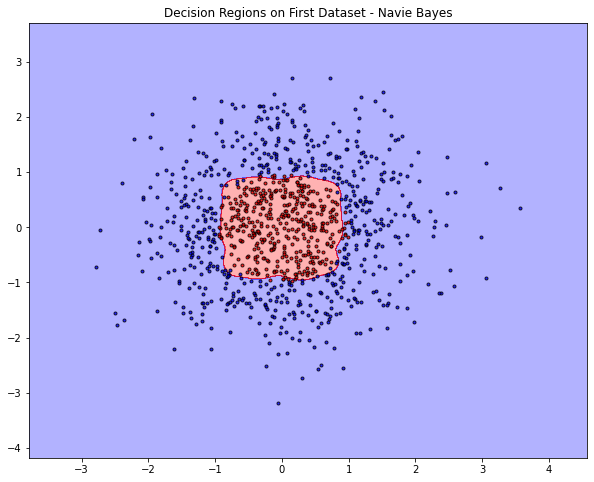

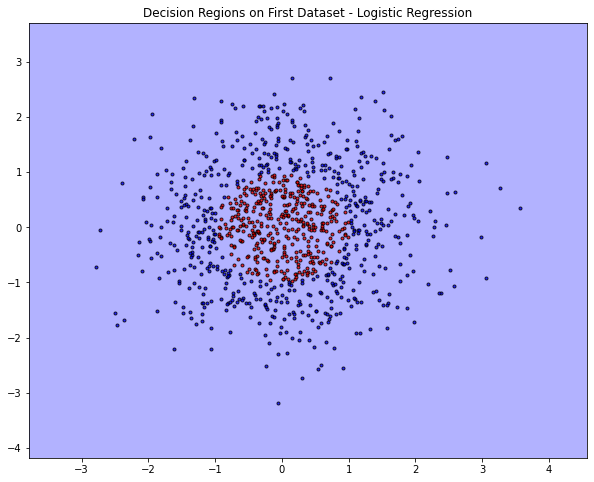

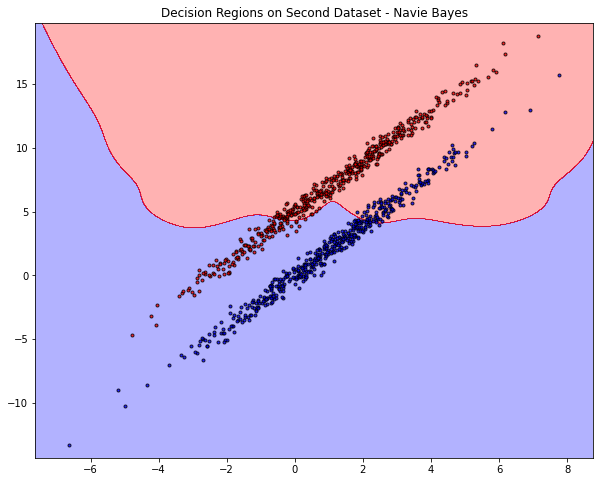

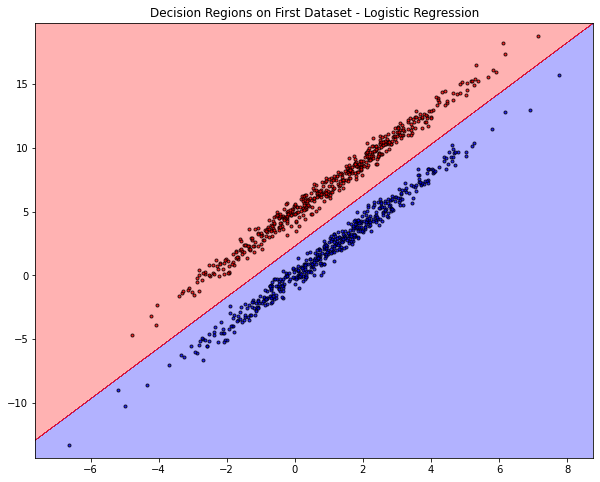

In [15]:
gaussian = NaiveBayesGaussian(k=4)
logist = LogisticRegressionGD(eta = 5e-05,eps = 1e-06)
gaussian.fit(Xd1,yd1)
logist.fit(Xd1,yd1)
plt.title("Decision Regions on First Dataset - Navie Bayes")
plot_decision_regions(Xd1,yd1,gaussian)
plt.show()
plt.title("Decision Regions on First Dataset - Logistic Regression")
plot_decision_regions(Xd1,yd1,logist)
plt.show()
gaussian.fit(Xd2,yd2)
logist.fit(Xd2,yd2)
plt.title("Decision Regions on Second Dataset - Navie Bayes")
plot_decision_regions(Xd2,yd2,gaussian)
plt.show()
plt.title("Decision Regions on First Dataset - Logistic Regression")
plot_decision_regions(Xd2,yd2,logist)
plt.show()


